<a href="https://colab.research.google.com/github/JulioLaz/robot_trading_bitcoin/blob/main/robot_trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Robot Trading

##Importacion de bibliotecas y libreias:

In [1]:
!python -V
print('------')
!pip show Pandas | grep 'Name\|Version'
print('------')
!pip show Numpy | grep 'Name\|Version'
print('------')
!pip show Matplotlib | grep 'Name\|Version'

Python 3.10.11
------
Name: pandas
Version: 1.5.3
------
Name: numpy
Version: 1.22.4
------
Name: matplotlib
Version: 3.7.1


In [30]:
import yfinance as yf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pandas._libs.lib import count_level_2d
import requests
from bs4 import BeautifulSoup
import yfinance as yf
from textblob import TextBlob
import pandas as pd
import time
from IPython.display import clear_output
import datetime
import pytz

# Obtener y tratar datos:

###1 - Obtener datos desde yahoo finance

### 2 - Nuevo df con columnas: DataTime(index) - Close - Volume


###3 - Eliminación de filas con volume=0

###4 - identificar índices duplicados y trátalos dejando sólo índices únicos

###5 - buscar valores nulos en la columna Close y trátalos:

In [3]:
#función obtencion y reacondicionamiento de datos:

def get_data():
    # 1 - Obtener datos desde yahoo finance:
    # Obtener los datos del último año con intervalos de 5 minutos
    symbol = "BTC-USD"
    period = "7d"
    interval = "5m"
    df = yf.download(symbol, period=period, interval=interval)

    # Guardar los datos en un dataframe
    df_bitcoin = pd.DataFrame(df)

    # 2 - Crear df con columnas: DataTime - Close - Volume
    df_bitcoin_limpio= df_bitcoin[['Close','Volume']]

    # 3 - Eliminar filas con volume=0
    df = df_bitcoin_limpio[df_bitcoin_limpio['Volume'] != 0]

    # 4 - Encontrar los índices duplicados
    duplicados = df.index.duplicated()

    # Eliminar las filas duplicadas
    df = df[~duplicados]

    # 5 - Elimina filas con Close=0
    df_bitcoin_limpio = df[df['Close'] != 0]

    return df_bitcoin_limpio

In [4]:
get_data()

[*********************100%***********************]  1 of 1 completed


,Close,Volume
Datetime,,
2023-05-05 00:30:00+00:00,28912.441406,3324928
2023-05-05 00:35:00+00:00,28913.117188,6749184
2023-05-05 00:40:00+00:00,28924.064453,34026496
2023-05-05 00:55:00+00:00,28945.613281,23319552
2023-05-05 01:05:00+00:00,28920.660156,10272768
...,...,...
2023-05-11 10:40:00+00:00,27488.263672,23431168
2023-05-11 10:45:00+00:00,27499.878906,12462080
2023-05-11 10:50:00+00:00,27494.019531,10536960


##Cálculos de valores estadísticos:

In [5]:
#Cálculos de valores estadísticos: df_bitcoin_limpio
def describir():
    df=get_data()
    media_bitcoin=int(df['Close'].mean())
    max=int(df['Close'].max())
    min=int(df['Close'].min())
    count=df['Close'].count()
    # print('Cantidad:',count, 'Media:',media_bitcoin,'Min:',min, 'Max:',max)
    return [media_bitcoin,max,min,count]

In [6]:
describir()

[*********************100%***********************]  1 of 1 completed


[28322, 29808, 27056, 956]

#identificar y eliminar los outliers

## utiliza un gráfico de boxplot:

In [7]:
def boxplot_grafico():
    df=get_data()

    sns.set(style="whitegrid", rc={"figure.figsize":(12,6)})

    cuartiles = [0, 0.25, 0.5, 0.75, 1]

    valores = df['Close'].quantile(cuartiles)

    colores = ['#4c72b0', '#55a868', '#c44e52', '#8172b2']

    sns.boxplot(y='Close', data=df, orient='v', palette=colores, whis=2, width=0.25)

    plt.axhline(y=valores[0], linestyle='--', color='#FFC0CB')
    plt.axhline(y=valores[1], linestyle='--', color='#FFC0CB')
    plt.axhline(y=df['Close'].mean(), linestyle='--', color='#FFC0CB')

    plt.text(-0.2, valores[0], f'Mínimo: {valores[0]:.0f}', fontsize=10, ha='center', va='bottom', color='#4682B4')
    plt.text(-0.2, valores[0.25], f'Q1: {valores[0.25]:.0f}', fontsize=10, ha='center', va='top', color='#1f77b4')
    plt.text(-0.2, valores[0.75], f'Q3: {valores[0.75]:.0f}', fontsize=10, ha='center', va='bottom', color='#1f77b4')
    plt.text(-0.2, valores[1], f'Máximo: {valores[1]:.0f}', fontsize=10, ha='center', va='bottom', color='#4682B4')
    plt.text(-0.2, df['Close'].mean(), f'Media: {df["Close"].mean():.0f}', fontsize=10, ha='center', va='top', color='#1f77b4')

    mediana = np.median(df['Close'])
    plt.text(-0.2, mediana, f'Mediana: {mediana:.0f}', fontsize=10, ha='center', va='bottom', color='black')

    plt.ylim(valores[0]-0.1*(valores[1]-valores[0]), valores[1]+0.1*(valores[1]-valores[0]))

    plt.title('Distribución de precios de Bitcoin en dólares', fontsize=16)

    return plt.show()


##Grafico boxplot:

[*********************100%***********************]  1 of 1 completed


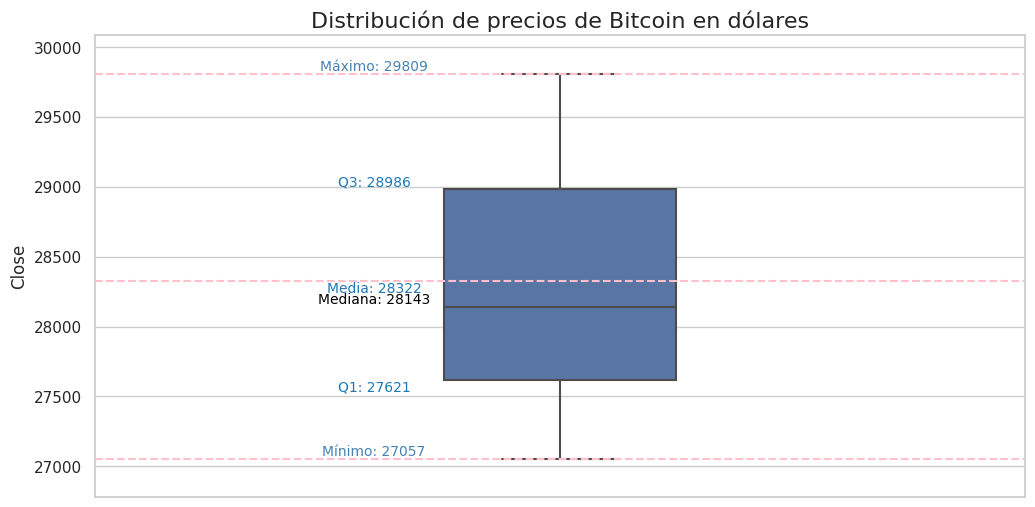

In [8]:
boxplot_grafico()

#Delimitando datos con query: entre Q1 y Q3

In [9]:
def between_quartiles():
    df=get_data()
    cuartiles = [0, 0.25, 0.5, 0.75, 1]
    valores = df['Close'].quantile(cuartiles)
    df_bitcoin_cuartiles = df.query('Close > ' + str(int(valores[0.25])) + ' & Close < ' + str(int(valores[0.75])))    
    
    # return df_bitcoin_cuartiles['Close']
    return df_bitcoin_cuartiles

In [10]:
between_quartiles()

[*********************100%***********************]  1 of 1 completed


,Close,Volume
Datetime,,
2023-05-05 00:30:00+00:00,28912.441406,3324928
2023-05-05 00:35:00+00:00,28913.117188,6749184
2023-05-05 00:40:00+00:00,28924.064453,34026496
2023-05-05 00:55:00+00:00,28945.613281,23319552
2023-05-05 01:05:00+00:00,28920.660156,10272768
...,...,...
2023-05-10 23:30:00+00:00,27625.246094,1019904
2023-05-10 23:35:00+00:00,27632.380859,21362688
2023-05-10 23:40:00+00:00,27623.425781,16363520


##Nuevo BOXPLOT desde Q1 a Q3

In [11]:
def new_boxplot():
    df_new= between_quartiles()

    sns.set(style="whitegrid", rc={"figure.figsize":(12,6)})

    cuartiles = [0, 0.25, 0.5, 0.75, 1]

    valores = df_new['Close'].quantile(cuartiles)

    colores = ['#4c72b0', '#55a868', '#c44e52', '#8172b2']

    sns.boxplot(y='Close', data=df_new, orient='v', palette=colores, whis=2, width=0.25)

    plt.axhline(y=valores[0], linestyle='--', color='#FFC0CB')
    plt.axhline(y=valores[1], linestyle='--', color='#FFC0CB')
    plt.axhline(y=df_new['Close'].mean(), linestyle='--', color='#FFC0CB')

    plt.text(-0.2, valores[0], f'Mínimo: {valores[0]:.0f}', fontsize=10, ha='center', va='bottom', color='#4682B4')
    plt.text(-0.2, valores[0.25], f'Q1: {valores[0.25]:.0f}', fontsize=10, ha='center', va='top', color='#1f77b4')
    plt.text(-0.2, valores[0.75], f'Q3: {valores[0.75]:.0f}', fontsize=10, ha='center', va='bottom', color='#1f77b4')
    plt.text(-0.2, valores[1], f'Máximo: {valores[1]:.0f}', fontsize=10, ha='center', va='bottom', color='#4682B4')
    plt.text(-0.2, df_new['Close'].mean(), f'Media: {df_new["Close"].mean():.0f}', fontsize=10, ha='center', va='top', color='#1f77b4')

    mediana = np.median(df_new['Close'])
    plt.text(-0.2, mediana, f'Mediana: {mediana:.0f}', fontsize=10, ha='center', va='bottom', color='black')

    plt.ylim(valores[0]-0.1*(valores[1]-valores[0]), valores[1]+0.1*(valores[1]-valores[0]))

    plt.title('Distribución de precios de Bitcoin en dólares', fontsize=16)

    return  plt.show();


[*********************100%***********************]  1 of 1 completed


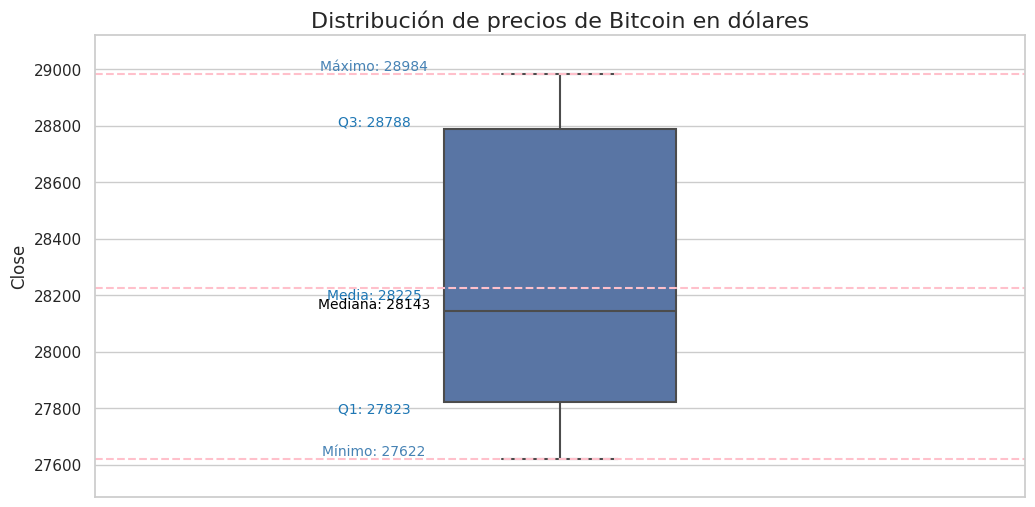

In [12]:
new_boxplot()

###Guardar en drive el df_bitcoin

In [13]:
df_new= between_quartiles()
df_new.to_csv('/content/drive/MyDrive/BitCoin/bitcoin.csv',sep=';',index='False')

[*********************100%***********************]  1 of 1 completed


#Extraer Tendencias:

In [14]:
def extraer_tendencias():
    global precio_actual, tendencia
    
    # Hacer la petición GET a la página web
    page = requests.get('https://coinmarketcap.com/')
    
    # Crear el objeto BeautifulSoup a partir del HTML de la página web
    soup = BeautifulSoup(page.content, 'html.parser')
    
    # Encontrar el precio actual del Bitcoin
    precio = soup.find('a', {'href': '/currencies/bitcoin/markets/'}).find('span').text.strip().replace('$', '').replace(',', '')

    # Convertir el precio a un número en coma flotante
    precio_actual = float(precio)

    # Análisis de tendencia a partir del icono up o down
    span_element = soup.find('span', {'class': ['icon-Caret-up', 'icon-Caret-down']})
    if 'icon-Caret-up' in span_element['class']:
        tendencia = 'Alta'
    else:
        tendencia = 'Baja'
    
    # Encontrar la variación del precio en la última hora
    porcentaje = soup.find('span', {'class': 'sc-97d6d2ca-0 bQjSqS'}).text.strip().replace('$', '').replace(',', '')
    
    # Actualizar la variable global tendencia
    return [int(precio_actual), tendencia,porcentaje]
    
extraer_tendencias()


[27478, 'Baja', '0.49%']

#Tomar decisiones

In [15]:
# Variables globales
symbol = "BTC-USD"
period = "7d" # días
interval = "5m" # minutos


def tomar_decisiones():
    global symbol, period, interval, df_bitcoin, precio_actual, tendencia, media_bitcoin, algoritmo_decision
    
    tendencia=extraer_tendencias()[1]
    df_bitcoin=between_quartiles()
    # Calcular el precio promedio
    media_bitcoin = between_quartiles()['Close'].mean()
    
    # Tomar la última fila del dataframe para obtener el precio actual
    precio_actual = extraer_tendencias()[0]
    
    # Determinar la tendencia en base a la diferencia entre el precio actual y el precio de hace 1 hora
    diferencia = precio_actual - between_quartiles()['Close'].iloc[-12]
    if diferencia > 0:
        tendencia = 'Alta'
    elif diferencia < 0:
        tendencia = 'Baja'
    else:
        tendencia = 'Neutral'
    
    # Aplicar el criterio de decisión
    if precio_actual >= media_bitcoin and tendencia == 'Baja':
        algoritmo_decision = 'Vender'
    elif precio_actual < media_bitcoin and tendencia == 'Alta':
        algoritmo_decision = 'Comprar'
    else:
        algoritmo_decision = 'Esperar'
    
    return algoritmo_decision


In [16]:
def print_algoritmo_decision():
    print('Decisión:', tomar_decisiones()),print('Tendencia:',tendencia),print('Media:',int(media_bitcoin)),print('Precio:',int(precio_actual))
    return

In [17]:
print_algoritmo_decision()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Decisión: Esperar
Tendencia: Baja
Media: 28225
Precio: 27478


#Gráfico de lineas para ver la tendencia

In [56]:
import matplotlib.pyplot as plt

def graficar():
    # crear la figura y los ejes
    fig, ax = plt.subplots()

    # trazar los datos en los ejes
    ax.plot(between_quartiles().index, between_quartiles()["Close"])

    # trazar una línea que indique el valor medio
    mean_price = between_quartiles()["Close"].mean()
    ax.axhline(mean_price, color="red", linestyle="--")

    # personalizar la apariencia del gráfico
    ax.set_xlabel("Fecha")
    ax.set_ylabel("Precio")
    ax.set_title("Evolución del Bitcoin a lo largo del tiempo")

    # mostrar la decisión del algoritmo_decision
    decision = tomar_decisiones()

    plt.annotate(f"Decisión: {decision}", xy=(between_quartiles().index[-1], between_quartiles()['Close'][-1]), 
                xytext=(-50, 50),textcoords='offset points', fontsize=10, color='red')
    # Mostrar decision en grafico
    ax.text(0.85, 0.95, f"Decisión: {decision}", transform=ax.transAxes, fontsize=20, color='red',
            verticalalignment='top',horizontalalignment='center', bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))

    # mostrar el gráfico
    # plt.show()
    return plt.show()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


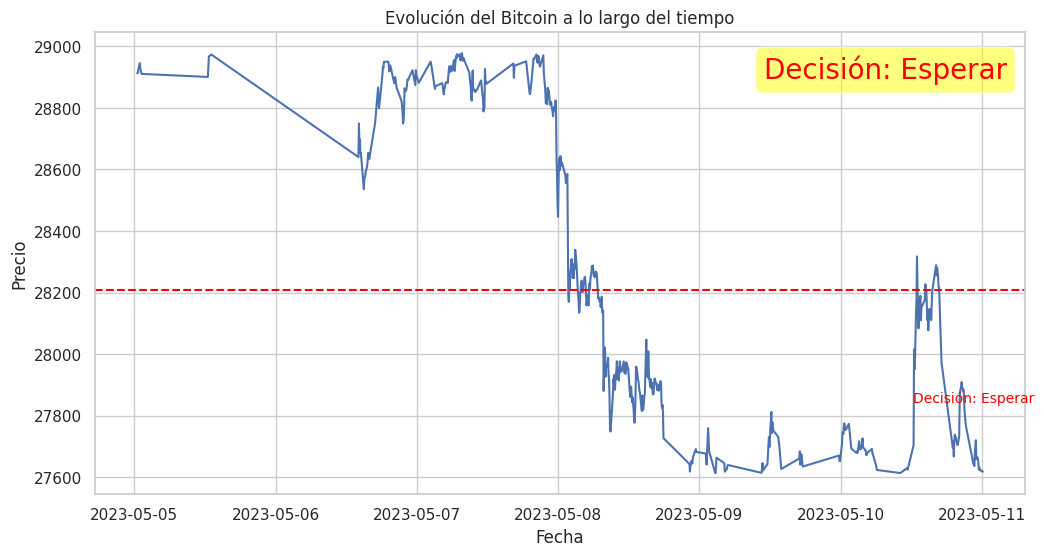

In [57]:
graficar()

#Automatizar:

In [38]:
def automatizar():
      contador=0
      while True:
          contador+=1
          get_data()
          between_quartiles()
          extraer_tendencias()
          tomar_decisiones()
          print_algoritmo_decision()
          
          tz = pytz.timezone('America/Argentina/Buenos_Aires')
          now = datetime.datetime.now(tz)
          print("Hora de verificación:", now.strftime("%H:%M:%S"))
          print("Ejecuciones: " ,contador," \n")
          print("-----------------------------------\n")
          graficar()
          clear_output(wait=True)

          time.sleep(300) #ciclo cada 300 segundos
      return

In [39]:
automatizar()

KeyboardInterrupt: ignored